In [2]:
%matplotlib inline

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Sample


In [168]:
df=pd.read_csv('sample_clusters.xlsx.csv')
df.head()

,x,y,n
0,1993,1678,149
1,1671,1755,149
2,1564,1917,148
3,2138,1619,147
4,2305,2223,149


In [169]:
for index, row in df.iterrows():
    curx = row['x']
    cury = row['y']    
    if index==0: 
        X = np.array([curx,cury], dtype='int64')
    else:
        oldX = X
        newX = np.array([curx,cury], dtype='int64')
        X=np.vstack((X,newX))

In [170]:
nobs = X.shape[0]

# Sample Viz

We can visualize the resulting data:



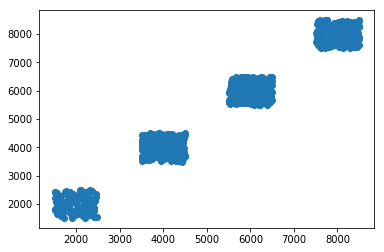

In [171]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# Distance matrix

In [172]:
# Distance matrix
from scipy.spatial import distance_matrix

In [173]:
dist_mat = distance_matrix(X, X, p=2)

In [174]:
dist_mat

array([[    0.        ,   331.07854053,   491.0824778 , ...,
         9006.26204371,  8660.21015911,  8961.97857619],
       [  331.07854053,     0.        ,   194.14685164, ...,
         9178.02075613,  8844.40755506,  9140.92670357],
       [  491.0824778 ,   194.14685164,     0.        , ...,
         9143.06786588,  8818.1146511 ,  9110.85605199],
       ..., 
       [ 9006.26204371,  9178.02075613,  9143.06786588, ...,
            0.        ,   522.97992313,   235.77955806],
       [ 8660.21015911,  8844.40755506,  8818.1146511 , ...,
          522.97992313,     0.        ,   343.49381363],
       [ 8961.97857619,  9140.92670357,  9110.85605199, ...,
          235.77955806,   343.49381363,     0.        ]])

In [220]:
# df_describe = pd.DataFrame(dist_mat)
df_describe = pd.DataFrame(dist_mat.flatten())
df_describe.describe()

,0
count,1000000.000000
mean,3355.470904
std,2387.492247
min,0.000000
25%,928.624117
50%,2948.627986
75%,5449.294931
max,9731.393528


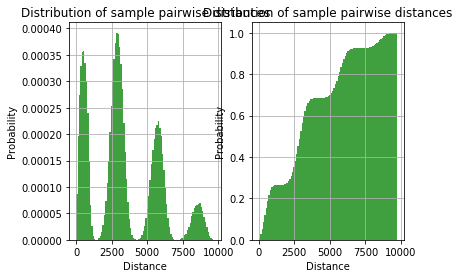

In [221]:
plt.subplot(1,2,1)
n, bins, patches = plt.hist(dist_mat.flatten(), 100, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Distance')
plt.ylabel('Probability')
plt.title('Distribution of sample pairwise distances')
plt.grid(True)
plt.subplot(1,2,2)
plt.hist(dist_mat.flatten(), bins=bins, density=True, facecolor='g', alpha=0.75, cumulative=True)
plt.xlabel('Distance')
plt.ylabel('Probability')
plt.title('Distribution of sample pairwise distances')
plt.grid(True)
plt.show()

# Neighbors at $\epsilon$ 

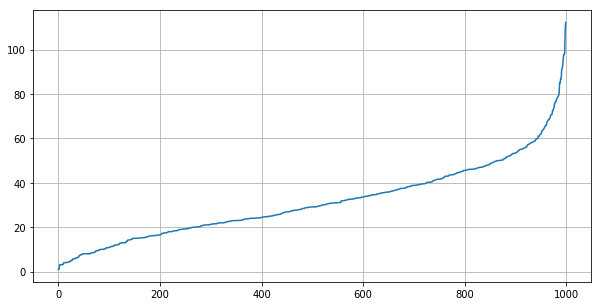

In [222]:
from sklearn.neighbors import NearestNeighbors
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(X)
distances, idx = nn.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)
plt.show()

In [234]:
# neighbors
# myeps = 60
myeps = 900
N = np.count_nonzero(dist_mat <= myeps, axis=0)

In [235]:
df_describe = pd.DataFrame(N)
df_describe.describe()

,0
count,1000.000000
mean,245.370000
std,52.051537
min,93.000000
25%,227.000000
50%,253.000000
75%,290.000000
max,300.000000


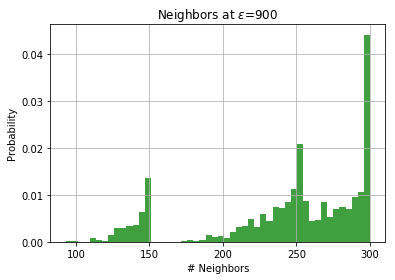

In [236]:
n, bins, patches = plt.hist(N, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [237]:
# loop within percentiles
for i in range(1, 100, 1):   
    minpts = np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps, min_samples=minpts).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_share = (n_noise/nobs)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    try: 
        silhout=metrics.silhouette_score(X, labels)
    except:
        silhout=None        
    if i==1:
        curdata = {'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]}
        df_pctiles = pd.DataFrame(curdata)
    else:
        curdata = {'pctile':i,'neighbors':minpts,'cluster_share':cluster_share,'conc_coeff':conc_coeff,
            'silhout':silhout,'n_clusters':n_clusters,'n_noise':n_noise, 'noise_share':noise_share}
        df_pctiles=df_pctiles.append(curdata, ignore_index=True)
df_pctiles.head()

,cluster_share,conc_coeff,n_clusters,n_noise,neighbors,noise_share,pctile,silhout
0,100.0,0.010101,4.0,0.0,122.99,0.0,1.0,0.80465
1,100.0,0.020408,4.0,0.0,129.00,0.0,2.0,0.80465
2,100.0,0.030928,4.0,0.0,131.97,0.0,3.0,0.80465
3,100.0,0.041667,4.0,0.0,135.00,0.0,4.0,0.80465
4,100.0,0.052632,4.0,0.0,138.00,0.0,5.0,0.80465


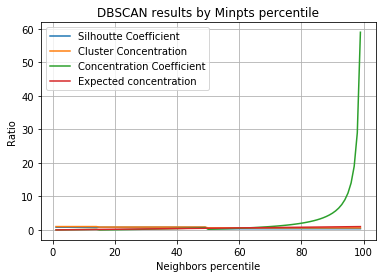

In [238]:
# plot lines
plt.plot(df_pctiles['pctile'], df_pctiles['silhout'], label = "Silhoutte Coefficient")
plt.plot(df_pctiles['pctile'], df_pctiles['cluster_share']/100, label = "Cluster Concentration")
plt.plot(df_pctiles['pctile'], df_pctiles['conc_coeff'], label = "Concentration Coefficient")
plt.plot(df_pctiles['pctile'], df_pctiles['pctile']/100, label = "Expected concentration")
plt.legend()
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.title('DBSCAN results by Minpts percentile')
plt.grid(True)
plt.show()

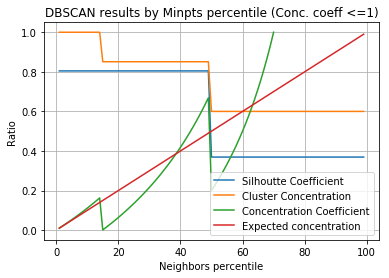

In [239]:
# plot lines
plt.plot(df_pctiles['pctile'], df_pctiles['silhout'], label = "Silhoutte Coefficient")
plt.plot(df_pctiles['pctile'], df_pctiles['cluster_share']/100, label = "Cluster Concentration")
plt.plot(df_pctiles[df_pctiles['conc_coeff']<=1]['pctile'], df_pctiles[df_pctiles['conc_coeff']<=1]['conc_coeff'], label = "Concentration Coefficient")
plt.plot(df_pctiles['pctile'], df_pctiles['pctile']/100, label = "Expected concentration")
plt.legend()
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.title('DBSCAN results by Minpts percentile (Conc. coeff <=1)')
plt.grid(True)
plt.show()

In [240]:
pd.set_option('display.max_rows', 100)
df_pctiles

,cluster_share,conc_coeff,n_clusters,n_noise,neighbors,noise_share,pctile,silhout
0,100.0,0.010101,4.0,0.0,122.99,0.0,1.0,0.804650
1,100.0,0.020408,4.0,0.0,129.00,0.0,2.0,0.804650
2,100.0,0.030928,4.0,0.0,131.97,0.0,3.0,0.804650
3,100.0,0.041667,4.0,0.0,135.00,0.0,4.0,0.804650
4,100.0,0.052632,4.0,0.0,138.00,0.0,5.0,0.804650
5,100.0,0.063830,4.0,0.0,140.94,0.0,6.0,0.804650
6,100.0,0.075269,4.0,0.0,143.93,0.0,7.0,0.804650
7,100.0,0.086957,4.0,0.0,145.00,0.0,8.0,0.804650
8,100.0,0.098901,4.0,0.0,146.00,0.0,9.0,0.804650
9,100.0,0.111111,4.0,0.0,147.00,0.0,10.0,0.804650


## Compute DBSCAN

One can access the labels assigned by :class:`~sklearn.cluster.DBSCAN` using
the `labels_` attribute. Noisy samples are given the label math:`-1`.



In [243]:
minpts = np.percentile(N, 14, axis=0)    
db = DBSCAN(eps=myeps, min_samples=minpts).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
conc_share_ = 1-n_noise_/nobs 

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")
print(f"Concentration share:  %.3f percent" % conc_share_)

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.805
Concentration share:  1.000 percent


## Plot results

Core samples (large dots) and non-core samples (small dots) are color-coded
according to the asigned cluster. Samples tagged as noise are represented in
black.



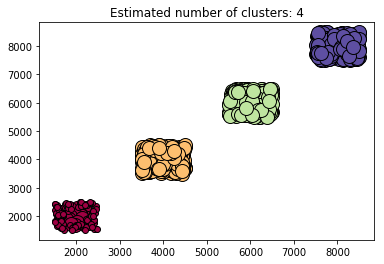

In [244]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()